# RATS - Revealing Atmospheres with Transmission Spectroscopy
## Purpose:
This is a python pipeline to analyse high-resolution spectra from largest ground-based telescopes, in particular using the transmission spectroscopy method for exoplanets. Here, we will show the basic usage of this package. In this notebook, the focus is on transmission spectroscopy pipeline. A separate notebook for Rossiter-McLaughlin pipeline is being written as well.

The package can be loaded simply as:

In [1]:
import rats

<div class="alert alert-block alert-warning">
<b>Warning:</b> Currently, RATS assumes data coming only from ESPRESSO and HARPS. NIRPS can be implemented simply, as the instrument uses the same DRS. However, other instruments require several functions to be implemented.
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> Generally, most functions and methods are well documented. You can get a hint by hovering mouse over the function name. You can also get the documentation by help(function).
</div>


## Before starting
Generally, the code assumes each dataset is in separate project folder. Therefore, before starting, please create a `main_directory` folder, where all the analysis will be done.

Usually, I assume following structure:

- `main_directory`
    - `code`
        - `transmission_spectroscopy_pipeline.py`
        - `rossiter_mclaughlin_pipeline.py`

Meaning, you need to create a `main_directory` folder with custom name. This is the folder where the pipeline is run in, and serves as `root_directory`. The subfolder for code (including the python files) is not strictly speaking necessary and the code should not break with other different ways of organizing. However, few fodlers are generated by the next set of routines.



## Single use routines
The first time a new analysis is done, several steps are necessary to perform before running the code. Right now, the code assumes data in the format as downloaded from DACE database. Generally, the steps needed are:

0. Check whether this routine set has been already run. This is done by existence of atleast one folder within the `spectroscopy_data` folder within the main project directory. 
1. Create a folder tree for the data, and distribute the files properly.

This can be done by `rats.single_use.setup_routine` function

`original_directory` corresponds to the folder where the zipped data downloaded from DACE are located. There is no issue if the data are already unzipped as well. `main_directory` corresponds to the location of the project.

<div class="alert alert-block alert-warning">
<b>Warning:</b> Please do not combine different datasets within one `original_directory`! The code has no way to differentiate between those.
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> If you need to rerun the `rats.single_use.setup_routine` function (e.g., adding new dataset), a `rerun` keyword is implemented. You can set it to `rerun=True` to rerun the function on the folder. However, please rerun this only on folder with the new data, don't include anything already run over by `setup_routine`, as it will likely duplicate the files.
</div>


In [2]:
import rats.single_use as su
original_directory = '/media/chamaeleontis/Observatory_main/Data_all_raw/WASP_31_b'
main_directory = '/media/chamaeleontis/Observatory_main/Analysis_dataset/WASP-31'
save_directory = main_directory + '/saved_data'
figure_directory = main_directory + '/figures'

su.setup_routine(original_directory= original_directory,
                 main_directory= main_directory
                 )

## Molecfit - telluric correction [optional]
The next step is to correct the data for telluric lines using `molecfit`. You can skip this case for first check of the pipeline, but for actual analysis some form of telluric correction is mandatory. This section assumes `molecfit` is installed on the computer through the `esoreflex` interface created by ESO. Check [ESO_molecfit](https://www.eso.org/sci/software/pipelines/skytools/molecfit) for more information on what `molecfit` is and how to install it.

<div class="alert alert-block alert-info">
<b>Tip:</b> Before proceeding with this step, please try to run the demo of the molecfit provided dataset and get familiar with `molecfit` structure.
</div>

Running the molecfit from the pipeline is simple calling of the `rats.run_molecfit_all.run_molecfit_all` function. This function checks the \spectroscopy_data\instrument\S1D\molecfit folder to correct for tellurics. By default, the `molecfit_input` subdirectory includes all the spectra needed for correction. 

For the wavelength region selection, a interactive GUI is generated on the first spectrum. Here, you can setup the `WAVE_INCLUDE` and `WAVE_EXCLUDE` parameters, that will be assumed for given night dataset. `Force_single` flag allow to run to the next spectrum assuming the selected wavelength region. `Force_all` flag allow to run all the spectra within the night with the selected region, without further interaction.
 

In [3]:
import rats.run_molecfit_all as mol
mol.run_molecfit_all(main_directory)


  INFO     | Running molecfit on folder:
  INFO     | /media/chamaeleontis/Observatory_main/Analysis_dataset/WASP-31/spectroscopy_data/ESPRESSO/2022-01-26/Fiber_A/S1D/molecfit
  WARNING  | The input directory is empty:
  WARNING  | Looking into directory:
  WARNING  | /media/chamaeleontis/Observatory_main/Analysis_dataset/WASP-31/spectroscopy_data/ESPRESSO/2022-01-26/Fiber_A/S1D/molecfit/molecfit_input
  INFO     | This can happen if molecfit has already been rerun completely.
  INFO     | In that case no action is needed and this warning can be ignored
  INFO     | Running molecfit on folder:
  INFO     | /media/chamaeleontis/Observatory_main/Analysis_dataset/WASP-31/spectroscopy_data/ESPRESSO/2022-02-12/Fiber_A/S1D/molecfit
  WARNING  | The input directory is empty:
  WARNING  | Looking into directory:
  WARNING  | /media/chamaeleontis/Observatory_main/Analysis_dataset/WASP-31/spectroscopy_data/ESPRESSO/2022-02-12/Fiber_A/S1D/molecfit/molecfit_input
  INFO     | This can happen if mo

## Load system parameters
System parameters are saved in a complex class system called `rats.parameters.SystemParametersComposite`. This class holds all the known parameters, including units, as set of `astropy.nddata.NDDataArray`. These also include the uncertainty of the parameter, which is correctly propagated with the `astropy` package. Unfortunately due to limitations on the `astropy` side, only single error value can be provided, removing option for uneven errorbars for the lower and upper error. By default, maximum of both is used. Please double check this for the generated tables (Tip below). 

The class has also convenience method `load_NASA_CompositeTable_values` to load NASA exoplanet archive values, given a planet name.

<div class="alert alert-block alert-warning">
<b>Warning:</b> The default NASA exoplanet archive values are not necessarilly the best possible one. Always check the values used in your pipeline to produce the result.
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> You can print the current system parameters used using the convenience method print_main_values. This prints the main set of system values.
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> You can save the current set of parameters as latex table using the create_system_table method. This allows you to copy-paste the code in your desired latex file.
</div>


In [4]:
import rats.parameters as para
import astropy.units as u # Handling of units
import astropy

system_parameters = para.SystemParametersComposite(
    # Filename is location of the files within the \saved_data subdirectory
    # It allows saving the parameters, removing the necessity to rerun the 
    # TAP service call to the NASA exoplanet archive every time.
    # By default, every week this function gets reloaded to check for updates.
    filename=save_directory + '/system_parameters.pkl'
    )

system_parameters.load_NASA_CompositeTable_values(
    # Planet name must be correct to the NASA syntax, with exact spacing.
    planet_name='WASP-31 b',
    # Forces loading the reloading the output. If True, TAP query is forced
    force_load=True
    )

# To change default parameter:
system_parameters.Star.metallicity = astropy.nddata.NDDataArray(
    data=-0.08,
    uncertainty=astropy.nddata.StdDevUncertainty(0.05),
    unit=u.dimensionless_unscaled,
    meta={'reference': 'Mortier et al. 2013',
        'parameter': 'Stellar metallicity'}
    )

system_parameters.print_main_values()

  INFO     | Loading NASA Exoplanet Composite table for planet: WASP-31 b
  INFO     | Loading finished.
  INFO     | Loading NASA Exoplanet Full Table for planet: WASP-31 b
  INFO     | Loading finished.
/media/chamaeleontis/Observatory_main/Code/rats/rats/parameters.py:126: RuntimeWarning: All-NaN axis encountered
  np.nanmax([CompositeTableRow[keyword + 'err1'],
  WARNING  | Add units for insolation flux
  INFO     | Calculation of gravity acceleration:
  INFO     |     4.94 m / s2
  INFO     | Calculated most precise ephemeris to current date.
  PRINT    | Transit window on night: 2024-10-04 13:35:21.250052
  PRINT    |     Calculated center: 2024-10-07 13:19:47.942366
  PRINT    |     Uncertainty: 0.19033622881627138 h [h]
  PRINT    |     Uncertainty: 11.420173728976282 min [min]
  PRINT    |     Uncertainty: 685.2104237385769 s [s]
  PRINT    | Transit window on night: 2024-10-04 13:35:21.250052
  PRINT    |     Calculated center: 2024-10-04 23:43:43.679969
  PRINT    |     Unce

## Loading spectra
Loading spectra is established within the `rats.load.eso` submodule. Other instruments could be implemented within the `rats.load` submodule, but there is no plan to do so.

Generally, spectra are saved as the `specutils.Spectrum1D` and `specutils.SpectralCollection` objects. Please refer to documentation [specutils documentation](https://specutils.readthedocs.io/en/stable/) for more info. Generally, list are saved as sp.SpectrumList, however a standard list of the python can be used as well.

Before loading spectra, lets change the working directory to the project directory. Generally, all formats and fibers can be loaded with single function, `eso.load_all`. This iterativelly loads the data over all nights and instruments. Only exception to format is telluric corrected data (with RATS pipeline using molecfit), loaded with different function, `rats.load.molecfit.molecfit_output`. In summary:

### For non-telluric corrected formats:
Run `rats.load.eso.load_all` function. As an input, choose a `spectra_format` available within the available formats, and the desired `fiber`.
### For telluric corrected format:
Run `rats.load.molecfit.molecfit_output`, given a mask threshold. This threshold masks all pixels where telluric profile was below this value. This is to mask the residual systematics in the data, caused by underestimated errors.


In [5]:
import os
os.chdir(main_directory)

import rats.load.eso as eso
data_raw_A = eso.load_all(main_directory= main_directory,
                          spectra_format= 'S1D',
                          fiber= 'A',
                          )
# Or
# import rats.load.molecfit as molload
# data_raw_A_tell_corrected, telluric_profiles, data_uncorrected = molload.molecfit_output(
#     main_directory=main_directory,
#     spectrum_type='S1D',
#     mask_threshold=0.5
#     )

  INFO     | Currently working on:
  INFO     |     load_all
  INFO     | Loading instrument: ESPRESSO
  INFO     | Currently working on:
  INFO     |     load_instrument
  INFO     | Loading night: /media/chamaeleontis/Observatory_main/Analysis_dataset/WASP-31/spectroscopy_data/ESPRESSO/2022-01-26
  INFO     | Currently working on:
  INFO     |     load_night
  INFO     | Loading night: /media/chamaeleontis/Observatory_main/Analysis_dataset/WASP-31/spectroscopy_data/ESPRESSO/2022-02-12
  INFO     | Currently working on:
  INFO     |     load_night
  INFO     | Loading night: /media/chamaeleontis/Observatory_main/Analysis_dataset/WASP-31/spectroscopy_data/ESPRESSO/2023-02-25
  INFO     | Currently working on:
  INFO     |     load_night
  INFO     | Loading instrument: HARPS
  INFO     | Currently working on:
  INFO     |     load_instrument
  INFO     | Loading night: /media/chamaeleontis/Observatory_main/Analysis_dataset/WASP-31/spectroscopy_data/HARPS/2016-04-12
  INFO     | Current

### Convenience region cut[optional]
These data are huge (>300000 pixels). Lets cut down the spectra to only short wavelength range to reduce the amount of computation. We can use a `rats.spectra_manipulation.extract_region_in_list` function to do so.

In [6]:
from rats.spectra_manipulation import extract_region_in_list
import specutils as sp
 
data_raw_A = extract_region_in_list(data_raw_A, sp.SpectralRegion(5886*u.AA,5900*u.AA))

### Meta parameters:
Each spectrum has its own `meta` dictionary. This dictionary holds information about the spectrum, including observations parameters like `airmass` and `BJD`. Furthermore, multiple functions assumes existence of a keywords within the spectrum, which needs to be added. We will use functionality within the `system_parameters` object.

In [7]:
system_parameters._update_contact_points()
system_parameters.spectra_transit_flags(data_raw_A)
system_parameters.calculate_velocities_list(data_raw_A)
system_parameters.add_velocity_system_in_list(data_raw_A)
system_parameters.calculate_local_stellar_velocity(data_raw_A)

  INFO     | spectra_transit_flags ran in 0.028854846954345703 seconds
  INFO     | calculate_velocities_list ran in 0.22741460800170898 seconds
  INFO     | add_velocity_system_in_list ran in 7.128715515136719e-05 seconds


### Data filtering
We can filter data based on the content of the meta dictionary. This is done by using the `rats.spectra_manipulation.get_sublist` method. `key` refers to the meta key to look for in the spectra, `value` corresponds to the value to compare with the `spectrum.meta[key]` content. `mode` changes a way of looking at the comparison, generally between being equal, non-equal, lower or higher than `value`.

For example, to get only data observed by `ESPRESSO`, you can do:

In [8]:
import rats.spectra_manipulation as sm
data_raw_A = sm.get_sublist(
    data_raw_A,
    key= 'instrument',
    value= 'ESPRESSO',
    mode='equal')

<div class="alert alert-block alert-info">
<b>Tip:</b> Mode allows you to choose between filtering by values lower or higher than some threshold, and values equal or non-equal to some value.
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> You can do a custom filter by creating a new meta keyword in the spectrum list.
</div>

### Spectrum cleaning:
The next few steps involve cleaning the spectra and normalizing them. The steps include (assuming `import rats.spectra_manipulation as sm`; this is going to be assumed for the rest of the notebook):


1. Sort spectrum list (`sm.sort_spectrum_list`)
2. Binning list to common wavelength grid (`sm.binning_list`)
3. Normalize list (`sm.normalize_list`)
4. Cosmic correction (`sm.cosmic_correction_all`)


In [9]:
data_raw_A = sm.sort_spectrum_list(data_raw_A)
data_binned = sm.binning_list(data_raw_A)
data_normalized = sm.normalize_list(data_binned)
data_cosmic_corrected = sm.cosmic_correction_all(data_normalized)

  INFO     | Currently working on:
  INFO     |     binning_list
  INFO     | Currently working on:
  INFO     |     normalize_list
  INFO     | Saved progress in /media/chamaeleontis/Observatory_main/Analysis_dataset/WASP-31/saved_data/normalize_list.pkl
  INFO     | Currently working on:
  INFO     |     cosmic_correction_all
  INFO     | Saved progress in /media/chamaeleontis/Observatory_main/Analysis_dataset/WASP-31/saved_data/cosmic_correction_all.pkl
  INFO     | cosmic_correction_all ran in 7.64697003364563 seconds


### Shifting to stellar rest frame
Now lets shift spectra to stellar rest frame. To do so `sm.shift_list` will shift the spectrum list. This iterativelly runs the `sm._shift_spectrum` on the list. The arguments `shift_velocity` assumes a scale, not the actual values of the velocity shift.

Meaning, to shift by BERV, you do `shift_BERV = 1`, to shift in negative direction `shift_BERV = -1`, to do no shift at all, `shift_BERV = 0`. The BERV (and other named velocities) are taken from the meta of each spectrum, set properly at loading and by system_parameters.

<div class="alert alert-block alert-info">
<b>Tip:</b> To use a custom velocity shift, you can use shift_constant, which unlike other arguments, is inputed as a Quantity as described by astropy.units module
</div>

To shift to rest frame of the star (assuming Solar barycenter as input data rest frame), do:

In [10]:
data_SRF = sm.shift_list(data_cosmic_corrected,
                        shift_BERV=0,
                        shift_v_sys=1,
                        shift_v_star=1,
                        shift_v_planet=0,
                        )

  INFO     | Currently working on:
  INFO     |     shift_list
  INFO     | Shifting spectrum number: 0/85
  INFO     | Shifting spectrum number: 1/85
  INFO     | Shifting spectrum number: 2/85
  INFO     | Shifting spectrum number: 3/85
  INFO     | Shifting spectrum number: 4/85
  INFO     | Shifting spectrum number: 5/85
  INFO     | Shifting spectrum number: 6/85
  INFO     | Shifting spectrum number: 7/85
  INFO     | Shifting spectrum number: 8/85
  INFO     | Shifting spectrum number: 9/85
  INFO     | Shifting spectrum number: 10/85
  INFO     | Shifting spectrum number: 11/85
  INFO     | Shifting spectrum number: 12/85
  INFO     | Shifting spectrum number: 13/85
  INFO     | Shifting spectrum number: 14/85
  INFO     | Shifting spectrum number: 15/85
  INFO     | Shifting spectrum number: 16/85
  INFO     | Shifting spectrum number: 17/85
  INFO     | Shifting spectrum number: 18/85
  INFO     | Shifting spectrum number: 19/85
  INFO     | Shifting spectrum number: 20/85
  

### Calculate master-out:
Master is generally called a representative value of given set of data. Here, we need some out-of-transit spectrum. This can be done in different ways, here we will do a weighted average by the average SNR of the spectrum.

To calculate a list of master spectra, a function `sm.calculate_master_list` is implemented.
It has two steps:
1. Filter only valid input spectra
2. Calculate the master given the `sn_type`

By setting `key='Transit_partial'` and `value=False`, we select only spectra with meta parameter `spectrum.meta['Transit_partial] = False`. This means only out-of-transit spectra. By sellecting `sn_type= 'quadratic'`, we select the weighting option.

The output has as first element the master out spectrum of full dataset, then each element is a separate night.

In [11]:
master_SRF_out = sm.calculate_master_list(data_SRF,
                                        key='Transit_partial',
                                        value=False,
                                        sn_type= 'quadratic',
                                        )

  INFO     | Currently working on:
  INFO     |     calculate_master_list
/media/chamaeleontis/Observatory_main/Code/rats/.venv/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/media/chamaeleontis/Observatory_main/Code/rats/.venv/lib/python3.10/site-packages/astropy/nddata/nduncertainty.py:883: RuntimeWarning: invalid value encountered in divide
  (left + right + correlation_sign * corr)
  INFO     | Saved progress in /media/chamaeleontis/Observatory_main/Analysis_dataset/WASP-31/saved_data/calculate_master_list.pkl


### Master-out correction
To correct for master out, a simple division is being done on the master out (night specific). This in principle provides transmission spectra (if data in transit), but the signal is rarely strong enough to be visible as is.

To correct for `master_out`, use:


In [12]:
data_out_corrected = sm.master_out_correction(spectrum_list= data_SRF,
                                              master_list= master_SRF_out,
                                              )

  INFO     | Currently working on:
  INFO     |     master_out_correction
  INFO     | Saved progress in /media/chamaeleontis/Observatory_main/Analysis_dataset/WASP-31/saved_data/master_out_correction.pkl


### Average transmission spectrum
Lets increase the signal-to-noise ratio of the transmission spectrum. To do so, we need to calculate an average transmission spectrum in the planetary rest frame.


In [13]:
data_PRF = sm.shift_list(data_out_corrected,
                        shift_BERV=0,
                        shift_v_sys=0,
                        shift_v_star=-1,
                        shift_v_planet=1,
                        )
transmission_spectrum = sm.calculate_master_list(data_PRF,
                                                key='Transit_full',
                                                value=True,
                                                sn_type='quadratic',
                                                )


  INFO     | Currently working on:
  INFO     |     shift_list
  INFO     | Shifting spectrum number: 0/85
  INFO     | Shifting spectrum number: 1/85
  INFO     | Shifting spectrum number: 2/85
  INFO     | Shifting spectrum number: 3/85
  INFO     | Shifting spectrum number: 4/85
  INFO     | Shifting spectrum number: 5/85
  INFO     | Shifting spectrum number: 6/85
  INFO     | Shifting spectrum number: 7/85
  INFO     | Shifting spectrum number: 8/85
  INFO     | Shifting spectrum number: 9/85
  INFO     | Shifting spectrum number: 10/85
  INFO     | Shifting spectrum number: 11/85
  INFO     | Shifting spectrum number: 12/85
  INFO     | Shifting spectrum number: 13/85
  INFO     | Shifting spectrum number: 14/85
  INFO     | Shifting spectrum number: 15/85
  INFO     | Shifting spectrum number: 16/85
  INFO     | Shifting spectrum number: 17/85
  INFO     | Shifting spectrum number: 18/85
  INFO     | Shifting spectrum number: 19/85
  INFO     | Shifting spectrum number: 20/85
  

### Final remarks:
This is the end of this tutorial. You can plot the result with several plotting function (below). This covers only the basics of transmission spectroscopy, multiple issues were not brought up in the pipeline. For example, ESPRESSO has wiggle component contamination that needs to be corrected, RM+CLV effects causes additional contamination in the data. Furthermore, cross-corellation has been also excluded from the discussion.
 
<div class="alert alert-block alert-info">
<b>Tip:</b> By default, absorption is aiming down in this representation. However, different representation can shift this, so always check carefully where the absorption is aiming.
</div>

<ErrorbarContainer object of 3 artists>

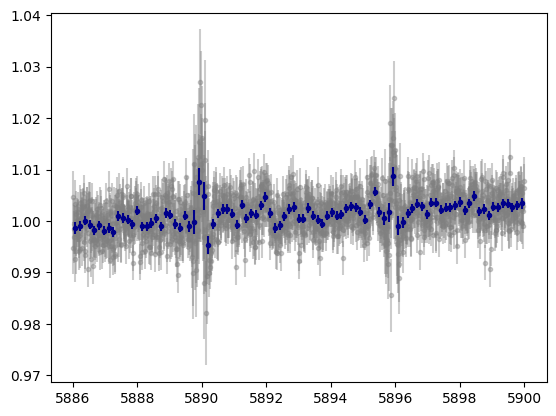

In [15]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1)
binning_factor = 15

ax.errorbar(transmission_spectrum[0].spectral_axis.value,
                transmission_spectrum[0].flux.value,
                transmission_spectrum[0].uncertainty.array,
                color = 'gray', fmt='.', alpha = 0.4,
                label='transmission spectrum')
x,y,yerr = sm.binning_spectrum(transmission_spectrum[0],binning_factor) 
ax.errorbar(x,
            y,
            yerr,
            color ='darkblue',
            zorder = 501,
            fmt='.',
            label='binned x15'
            )
